In [ ]:
! pip install rdkit
! pip install torch_geometric
! pip install transformers
! pip install biopython
! pip install numpy
! pip install suds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 13.1 MB/s eta 0:00:00


# Imports

In [ ]:
import pandas as pd
from os.path import join
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
import rdkit
from rdkit.Chem import AllChem
from Bio.PDB import PDBList, PDBParser
import numpy as np
import requests
from sklearn.metrics import r2_score
import pickle
import torch
import networkx as nx
import numpy as np
from Bio.PDB import PDBParser, PDBList, NeighborSearch
from torch_geometric.data import Data
from scipy.spatial import KDTree
import logging
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
# Define your inchi_to_graph function here
# and any other necessary functions or imports


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data from Google Drive

In [ ]:
# Generate numbers from 200 to 3400 with a step of 200
data_train = []
# numbers = list(range(200, 3401, 200))
numbers = list(range(200, 3401, 200))
for number in numbers:

  file_path = '/content/drive/My Drive/kcat_minidatasets/trainNew' + str(number) + '.pkl'
  # Load the list from the specified file
  with open(file_path, 'rb') as file:
      data= pickle.load(file)

  data_train = data_train + data

In [ ]:
def create_default_protein_graph():
    """Create a default protein graph with predefined nodes and edges."""
    graph = nx.Graph()
    # Define a few nodes with arbitrary features
    default_features = [
        [1] * 20 + [1.8, 8.1, 0, 0, 0, 0],  # Node 0 (ALA)
        [0] * 20 + [2.5, 5.5, 0, 1, 1, 1],  # Node 1 (CYS)
        [0] * 20 + [-3.5, 13.0, -1, 2, 2, 2],  # Node 2 (ASP)
        [0] * 20 + [4.5, 5.2, 0, 3, 3, 3]  # Node 3 (ILE)
    ]
    for idx, features in enumerate(default_features):
        graph.add_node(idx, feature=features)

    # Add some edges with arbitrary distances
    graph.add_edge(0, 1, weight=4.0)
    graph.add_edge(1, 2, weight=5.0)
    graph.add_edge(2, 3, weight=6.0)
    graph.add_edge(3, 0, weight=4.5)

    return graph_to_pyg_data(graph)

def graph_to_pyg_data(graph):
    try:
        node_features = [data['feature'] for _, data in graph.nodes(data=True)]
        x = torch.tensor(node_features, dtype=torch.float)

        edge_index = []
        edge_attr = []
        for edge in graph.edges(data=True):
            edge_index.append([edge[0], edge[1]])
            edge_index.append([edge[1], edge[0]])
            edge_attr.append([edge[2]['weight']])
            edge_attr.append([edge[2]['weight']])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data

    except Exception as e:
        logging.error(f"Error converting graph to PyG data: {e}")
        return None
x = create_default_protein_graph()
x

Data(x=[4, 26], edge_index=[2, 8], edge_attr=[8, 1])

# Default Graph when there is no matching graph in PDB

In [ ]:
cleaned_data = []
for item in data_train:

  if item['protein_graph'] is None:
    # print(item['aggregated_substrate_graph'], item['aggregated_product_graph'], item['protein_graph'])
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_data.append(item)

cleaned_complete_data_train = []
for item in cleaned_data:
  # if item['aggregated_substrate_graph'].edge_index.shape[1] == 12:
  if item['protein_graph'].edge_index.shape == torch.Size([0]):
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_complete_data_train.append(item)

In [ ]:
len(cleaned_complete_data_train)

3417

In [ ]:
# Generate numbers from 200 to 3400 with a step of 200
data_test = []
# numbers = list(range(200, 3401, 200))
numbers = list(range(200, 801, 200))
for number in numbers:

  file_path = '/content/drive/My Drive/kcat_minidatasets/testNew' + str(number) + '.pkl'
  # Load the list from the specified file
  with open(file_path, 'rb') as file:
      data= pickle.load(file)

  data_test = data_test + data

file_path = '/content/drive/My Drive/kcat_minidatasets/testNew849.pkl'
  # Load the list from the specified file
with open(file_path, 'rb') as file:
    data= pickle.load(file)

data_test = data_test + data

cleaned_data = []
for item in data_test:

  if item['protein_graph'] is None:
    # print(item['aggregated_substrate_graph'], item['aggregated_product_graph'], item['protein_graph'])
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_data.append(item)

cleaned_complete_data_test = []
for item in cleaned_data:
  # if item['aggregated_substrate_graph'].edge_index.shape[1] == 12:
  if item['protein_graph'].edge_index.shape == torch.Size([0]):
    item['protein_graph'] = create_default_protein_graph()
    cleaned_data.append(item)

  else:
    cleaned_complete_data_test.append(item)

In [ ]:
# Check if GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating PyTorch datasets

In [ ]:
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class KcatDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # combined_data = self.data_list[idx]['combined']
        combined_data = self.data_list[idx]['aggregated_substrate_graph']
        protein_data = self.data_list[idx]['protein_graph']
        log10_kcat = self.data_list[idx]['log10_kcat']
        protein_embedding = self.data_list[idx]['esm_embedding']
        fingerprint = self.data_list[idx]['fingerprint'][0]

        # Move data to the device
        combined_data = combined_data.to(self.device)
        protein_data = protein_data.to(self.device)
        protein_embedding = torch.tensor(protein_embedding).to(self.device)
        fingerprint = torch.tensor(fingerprint).to(self.device)

        return combined_data, protein_data, protein_embedding, fingerprint, log10_kcat


# data = cleaned_complete_data_train + cleaned_complete_data_test
# data_train, data_test = train_test_split(data, test_size=0.1,)

train_kcat_dataset = KcatDataset(cleaned_complete_data_train, device)
test_kcat_dataset = KcatDataset(cleaned_complete_data_test, device)

train_data_loader = DataLoader(train_kcat_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_kcat_dataset, batch_size=64)
test_data_loader_big = DataLoader(test_kcat_dataset, batch_size=854)



# GCN Combined Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch

class GCNSection(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNSection, self).__init__()
        self.gcn1 = GCNConv(in_channels, out_channels)
        self.gcn2 = GCNConv(out_channels, out_channels)
        self.gcn3 = GCNConv(out_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.gcn2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.gcn3(x, edge_index)
        x = global_mean_pool(x, batch)  # Pooling to get batch-wise embeddings
        return x

class ProteinGCNModel(nn.Module):
    def __init__(self, in_channels, out_channels, esm_embedding_dim, hidden_dim, final_out_dim):
        super(ProteinGCNModel, self).__init__()
        self.protein_gcn = GCNSection(in_channels, out_channels)

        # Linear layers after concatenation of GCN and ESM embeddings
        combined_dim = out_channels + esm_embedding_dim
        self.fc1 = nn.Linear(combined_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, final_out_dim)

    def forward(self, protein_data, esm_embeddings):
        # GCN for protein section
        protein_x, protein_edge_index, protein_batch = protein_data.x, protein_data.edge_index, protein_data.batch

        protein_embedding = self.protein_gcn(protein_x, protein_edge_index, protein_batch)

        # Ensure esm_embeddings is batch-wise
        if esm_embeddings.dim() == 2 and esm_embeddings.size(0) == protein_embedding.size(0):
            combined_embedding = torch.cat([protein_embedding, esm_embeddings], dim=-1)
        else:
            raise ValueError("Mismatch in batch size between embeddings and data")

        x = F.relu(self.fc1(combined_embedding))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SubstrateGCNModel(nn.Module):
    def __init__(self, in_channels, out_channels, substrate_embedding_dim, hidden_dim, final_out_dim):
        super(SubstrateGCNModel, self).__init__()
        self.substrate_gcn = GCNSection(in_channels, out_channels)

        # Linear layers after concatenation of GCN and substrate embeddings
        combined_dim = out_channels + substrate_embedding_dim
        self.fc1 = nn.Linear(combined_dim, 32)
        self.fc2 = nn.Linear(32, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, final_out_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, substrate_data, substrate_embeddings):
        # GCN for substrate section
        substrate_x, substrate_edge_index, substrate_batch = substrate_data.x, substrate_data.edge_index, substrate_data.batch
        substrate_embedding = self.substrate_gcn(substrate_x, substrate_edge_index, substrate_batch)

        # Ensure substrate_embeddings is batch-wise
        if substrate_embeddings.dim() == 2 and substrate_embeddings.size(0) == substrate_embedding.size(0):
            combined_embedding = torch.cat([substrate_embedding, substrate_embeddings], dim=-1)
        else:
            raise ValueError("Mismatch in batch size between embeddings and data")

        # Pass through linear layers
        x = F.relu(self.fc1(combined_embedding))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

# Define input parameters
protein_in_channels = 26  # Example input channel size for proteins
substrate_in_channels = 6  # Example input channel size for substrates
out_channels = 128  # Output channels for GCN layers
esm_embedding_dim = 1280  # ESM embedding dimension for proteins
substrate_embedding_dim = 2048  # Embedding dimension for substrates
protein_hidden_dim = 16  # Hidden dimension for the linear layer
molecule_hidden_dim=8
final_out_dim = 1  # Final output dimension

# Create instances of the models
protein_model = ProteinGCNModel(
    in_channels=protein_in_channels,
    out_channels=out_channels,
    esm_embedding_dim=esm_embedding_dim,
    hidden_dim=protein_hidden_dim,
    final_out_dim=final_out_dim
)

substrate_model = SubstrateGCNModel(
    in_channels=substrate_in_channels,
    out_channels=out_channels,
    substrate_embedding_dim=substrate_embedding_dim,
    hidden_dim=molecule_hidden_dim,
    final_out_dim=final_out_dim
)

protein_model = protein_model.to(device)
substrate_model = substrate_model.to(device)

optimizer_protein = torch.optim.Adam(protein_model.parameters(), lr=0.0005, weight_decay=0.003)
optimizer_substrate = torch.optim.Adam(substrate_model.parameters(), lr=0.0005, weight_decay=0.003)


# Functions to print loss and R2

In [ ]:

# Example instantiation of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_loss(train_scores, test_scores):
    plt.figure()
    plt.plot(train_scores, label='Train Loss')
    plt.plot(test_scores, label='Test Loss')
    plt.title('Separated GCN - Protein model train and test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_r2(train_r2, test_r2):
    plt.figure()
    plt.plot(train_r2, label='Train R2 Score')
    plt.plot(test_r2, label='Test R2 Score')
    plt.title('Separated GCN - Protein model R2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.show()




# Training function

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
import copy

def train_model(train_data_loader, test_data_loader, device, model, optimizer, model_type, epochs, print_out=True):
    train_scores = []
    test_scores = []
    test_r2_score = []
    train_r2_score = []
    best_test_r2 = -1000
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_total_loss = 0
        all_outputs = []
        all_targets = []

        for mol_batch, prot_batch, esm_embedding, fingerprint, targets in train_data_loader:
            targets = torch.tensor(targets).float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            if model_type == 'protein':
                output = model(prot_batch, esm_embedding)
            elif model_type == 'substrate':
                output = model(mol_batch, fingerprint.float())

            if output is not None:
                loss = F.mse_loss(output, targets)
                loss.backward()
                optimizer.step()
                train_total_loss += loss.item()
                all_outputs.extend(output.detach().cpu().numpy())
                all_targets.extend(targets.detach().cpu().numpy())

        r2 = r2_score(all_targets, all_outputs)
        train_r2_score.append(r2)
        if print_out:
            print(f"Epoch {epoch}, Train Loss: {train_total_loss / len(train_data_loader)}, Train R2: {r2}")

        model.eval()
        total_test_loss = 0
        all_outputs = []
        all_targets = []

        with torch.no_grad():
            for mol_batch, prot_batch, esm_embedding, fingerprint, targets in test_data_loader:
                targets = torch.tensor(targets).float().unsqueeze(1).to(device)

                if model_type == 'protein':
                    output = model(prot_batch, esm_embedding)
                elif model_type == 'substrate':
                    output = model(mol_batch, fingerprint.float())

                if output is not None:
                    loss = F.mse_loss(output, targets)
                    total_test_loss += loss.item()
                    all_outputs.extend(output.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())

        average_test_loss = total_test_loss / len(test_data_loader)
        test_scores.append(average_test_loss)
        if print_out:
            print(f"Epoch {epoch}, Test Loss: {average_test_loss}")

        r2 = r2_score(all_targets, all_outputs)
        test_r2_score.append(r2)
        if print_out:
            print(f"Epoch {epoch}, Test R2: {r2}")

        # Save the model if it has the best test loss so far
        if r2 > best_test_r2:
            best_test_r2 = r2
            best_model_state = copy.deepcopy(model.state_dict())

        train_scores.append(train_total_loss / len(train_data_loader))
    if print_out:
      print("best r2", best_test_r2)
    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    if print_out:
        plot_loss(train_scores, test_scores)
        plot_r2(train_r2_score, test_r2_score)

    return model




Epoch 0, Train Loss: 1.6627349698985066, Train R2: -0.1930792136497259
Epoch 0, Test Loss: 1.4611682466098241
Epoch 0, Test R2: -0.01561944910031321
Epoch 1, Train Loss: 1.349870687281644, Train R2: 0.032320018043495935
Epoch 1, Test Loss: 1.3805386509214128
Epoch 1, Test R2: 0.045765452938973494
Epoch 2, Train Loss: 1.2850758775516793, Train R2: 0.07651780579402123
Epoch 2, Test Loss: 1.3356547823974065
Epoch 2, Test R2: 0.07873759640216627
Epoch 3, Train Loss: 1.1925556383751057, Train R2: 0.14151282092100637
Epoch 3, Test Loss: 1.2469488893236433
Epoch 3, Test R2: 0.13863417308340886
Epoch 4, Train Loss: 1.0973321199417114, Train R2: 0.20987676931742327
Epoch 4, Test Loss: 1.1905913821288518
Epoch 4, Test R2: 0.17850888877602733
Epoch 5, Train Loss: 1.0490231425673873, Train R2: 0.25021010614309636
Epoch 5, Test Loss: 1.1472798671041216
Epoch 5, Test R2: 0.20828429551280225
Epoch 6, Train Loss: 1.0048153400421143, Train R2: 0.27961397230603924
Epoch 6, Test Loss: 1.1207860112190247


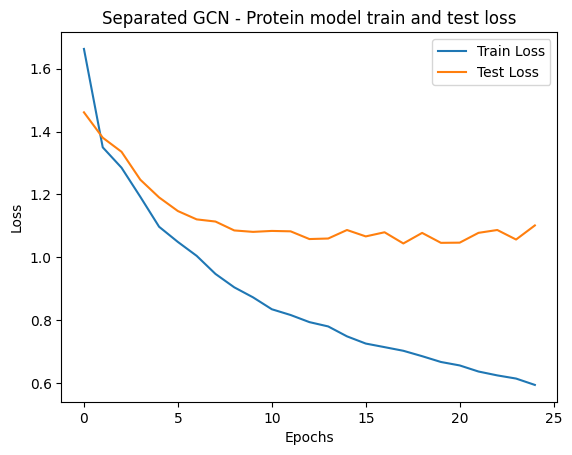

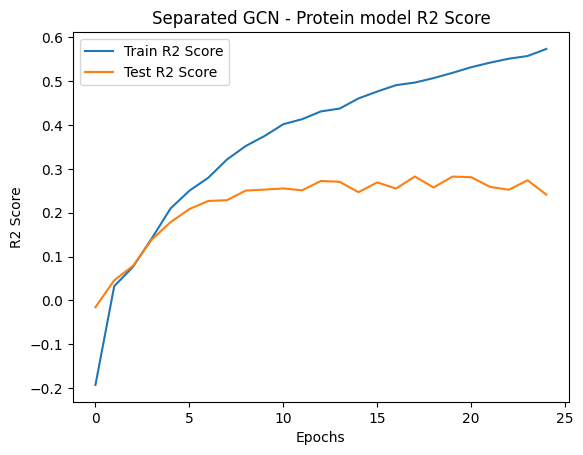

In [ ]:
# Train protein model
trained_protein_model = train_model(train_data_loader, test_data_loader, device, protein_model, optimizer_protein, model_type='protein', epochs=25, print_out=True)


In [ ]:

# Example instantiation of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_loss(train_scores, test_scores):
    plt.figure()
    plt.plot(train_scores, label='Train Loss')
    plt.plot(test_scores, label='Test Loss')
    plt.title('Separated GCN - Molecule model train and test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_r2(train_r2, test_r2):
    plt.figure()
    plt.plot(train_r2, label='Train R2 Score')
    plt.plot(test_r2, label='Test R2 Score')
    plt.title('Separated GCN - Molecule model R2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.show()




Epoch 0, Train Loss: 2.2637150044794434, Train R2: -0.6318152059254916
Epoch 0, Test Loss: 1.368739596435002
Epoch 0, Test R2: 0.03851772648930074
Epoch 1, Train Loss: 1.0986247923639085, Train R2: 0.2145375529553386
Epoch 1, Test Loss: 1.2080131386007582
Epoch 1, Test R2: 0.1571152838404548
Epoch 2, Train Loss: 1.0150688643808718, Train R2: 0.27404210356865044
Epoch 2, Test Loss: 1.1239943589482988
Epoch 2, Test R2: 0.21987607448134627
Epoch 3, Train Loss: 0.8798765871259902, Train R2: 0.3705051185934287
Epoch 3, Test Loss: 1.09283424275262
Epoch 3, Test R2: 0.24090947954049713
Epoch 4, Train Loss: 0.8090894702408049, Train R2: 0.4224154842154878
Epoch 4, Test Loss: 1.0457478208201272
Epoch 4, Test R2: 0.27485796767718484
Epoch 5, Train Loss: 0.7760615933824468, Train R2: 0.44205968635559245
Epoch 5, Test Loss: 1.053416324513299
Epoch 5, Test R2: 0.2695312209298406
Epoch 6, Train Loss: 0.7559211977102138, Train R2: 0.4554731968925777
Epoch 6, Test Loss: 1.0081127882003784
Epoch 6, Tes

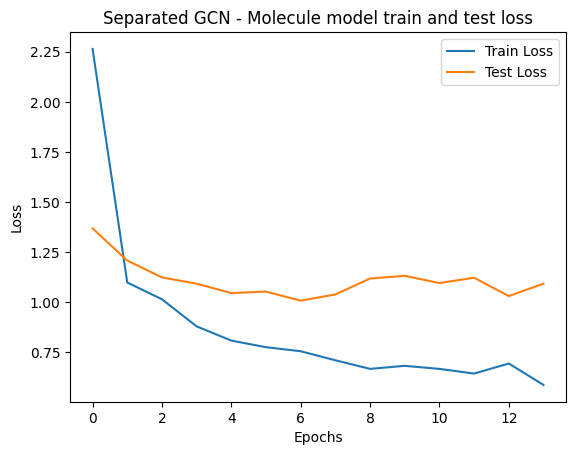

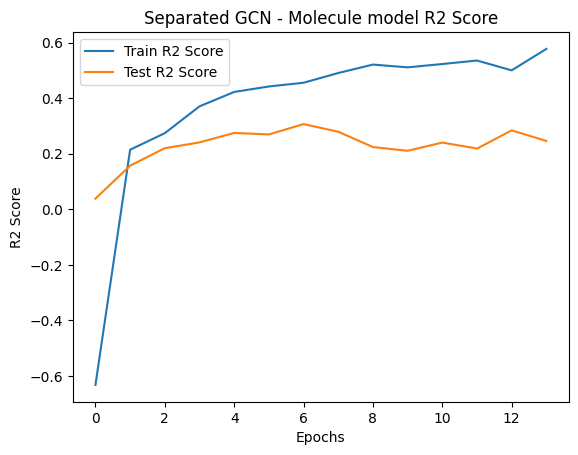

In [ ]:
# Train substrate model
trained_substrate_model = train_model(train_data_loader, test_data_loader, device, substrate_model, optimizer_substrate, model_type='substrate', epochs=14, print_out=True)

In [ ]:
protein_params = sum(p.numel() for p in protein_model.parameters() if p.requires_grad)
molecule_params = sum(p.numel() for p in substrate_model.parameters() if p.requires_grad)

print(f"Protein Model Parameters: {protein_params}")
print(f"Molecule Model Parameters: {molecule_params}")

Protein Model Parameters: 59313
Molecule Model Parameters: 103857


# Ensemble model

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score

def evaluate_ensemble(model1, model2, test_data_loader):
    model1.eval()
    model2.eval()

    total_test_loss = 0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for mol_batch, prot_batch, esm_embedding, fingerprint, targets in test_data_loader_big:
            targets = torch.tensor(targets).float().unsqueeze(1).to(device)

            output1 = model1(prot_batch, esm_embedding)

            output2 = model2(mol_batch, fingerprint.float())

            # Ensemble prediction by averaging outputs
            output = (output1 + output2) / 2

            if output is not None:
                loss = F.mse_loss(output, targets)
                total_test_loss += loss.item()
                all_outputs.extend(output.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

    average_test_loss = total_test_loss / len(test_data_loader_big)


    # Calculate R2 score
    r2 = r2_score(all_targets, all_outputs)

    # print(f"Ensemble Test Loss: {average_test_loss}")
    # print(f"R2 Score: {r2}")
    return r2

# Example usage
r2= evaluate_ensemble(trained_protein_model, trained_substrate_model, test_data_loader)
print(f"R2 Score: {r2}")

R2 Score: 0.37868834918713146


In [ ]:
def get_default_models():

  # Create instances of the models
  protein_model = ProteinGCNModel(
      in_channels=protein_in_channels,
      out_channels=out_channels,
      esm_embedding_dim=esm_embedding_dim,
      hidden_dim=protein_hidden_dim,
      final_out_dim=final_out_dim
  )

  substrate_model = SubstrateGCNModel(
      in_channels=substrate_in_channels,
      out_channels=out_channels,
      substrate_embedding_dim=substrate_embedding_dim,
      hidden_dim=molecule_hidden_dim,
      final_out_dim=final_out_dim
  )

  protein_model = protein_model.to(device)
  substrate_model = substrate_model.to(device)

  optimizer_protein = torch.optim.Adam(protein_model.parameters(), lr=0.0005, weight_decay=0.003)
  optimizer_substrate = torch.optim.Adam(substrate_model.parameters(), lr=0.0005, weight_decay=0.003)

  return protein_model, substrate_model, optimizer_protein, optimizer_substrate

# Testing performance 10 times

In [ ]:
results = []
for i in range(10):
  protein_model, substrate_model, optimizer_protein, optimizer_substrate = get_default_models()
  trained_protein_model = train_model(train_data_loader, test_data_loader, device, protein_model, optimizer_protein, model_type='protein', epochs=25, print_out=False)
  trained_substrate_model = train_model(train_data_loader, test_data_loader, device, substrate_model, optimizer_substrate, model_type='substrate', epochs=12, print_out=False)
  results.append(evaluate_ensemble(trained_protein_model, trained_substrate_model, test_data_loader))

In [ ]:
import statistics
print("10 times avg test results")
print("Mean:", statistics.mean(results))
print("Standard Deviation: ", statistics.stdev(results))

10 times avg test results
Mean: 0.3960636076605954
Standard Deviation:  0.009511520860613427


In [ ]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score


X_train = []
y_train = []
for item in cleaned_complete_data_train:
  # print(item['esm_embedding'], item['fingerprint'][0])
  combined = np.concatenate((item['esm_embedding'], item['fingerprint'][0]))
  X_train.append(combined)
  y_train.append(item['log10_kcat'])

# for item in cleaned_complete_data_test[0:400]:
#   combined = np.concatenate((item['esm_embedding'], item['fingerprint'][0]))
#   X_train.append(combined)
#   y_train.append(item['log10_kcat'])

X_test = []
y_test = []
for item in cleaned_complete_data_test:
  combined = np.concatenate((item['esm_embedding'], item['fingerprint'][0]))
  X_test.append(combined)
  y_test.append(item['log10_kcat'])



# Convert the dataset into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',  # regression objective
    'max_depth': 9,  # maximum depth of the trees
    'eta': 0.1,  # learning rate
    'eval_metric': 'rmse'  # evaluation metric
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.2f}')
r2_scoring = r2_score(y_test, y_pred)
print(f'R2 Score: {r2_scoring:.2f}')

RMSE: 0.95
R2 Score: 0.37


# 3 way ensemble with XGBoost

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
import xgboost as xgb
import numpy as np

def evaluate_three_way_ensemble(model1, model2, xgb_model, test_data_loader, device):
    model1.eval()
    model2.eval()

    total_test_loss = 0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for mol_batch, prot_batch, esm_embedding, fingerprint, targets in test_data_loader_big:
            targets = torch.tensor(targets).float().unsqueeze(1).to(device)

            # Get outputs from the PyTorch models
            output1 = model1(prot_batch, esm_embedding)
            output2 = model2(mol_batch, fingerprint.float())

            # Prepare data for XGBoost
            combined_features = np.concatenate((esm_embedding.cpu().numpy(), fingerprint.cpu().numpy()), axis=1)
            xgb_input = xgb.DMatrix(combined_features)
            output3 = xgb_model.predict(xgb_input)
            output3 = torch.tensor(output3).float().unsqueeze(1).to(device)

            # Ensemble prediction by averaging outputs
            output = ((output1 + output2)/2 + output3) / 2

            if output is not None:
                loss = F.mse_loss(output, targets)
                total_test_loss += loss.item()
                all_outputs.extend(output.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

    average_test_loss = total_test_loss / len(test_data_loader)

    # Calculate R2 score
    r2 = r2_score(all_targets, all_outputs)

    # print(f"Three-Way Ensemble R2 Score: {r2}")
    return r2
# Example usage
evaluate_three_way_ensemble(trained_protein_model, trained_substrate_model, xgb_model, test_data_loader, device)


0.422089807764536

# 10 time avg test run

In [ ]:
def get_default_models():
  protein_model = ProteinGCNModel(
      in_channels=protein_in_channels,
      out_channels=out_channels,
      esm_embedding_dim=esm_embedding_dim,
      hidden_dim=protein_hidden_dim,
      final_out_dim=final_out_dim
  )

  substrate_model = SubstrateGCNModel(
      in_channels=substrate_in_channels,
      out_channels=out_channels,
      substrate_embedding_dim=substrate_embedding_dim,
      hidden_dim=molecule_hidden_dim,
      final_out_dim=final_out_dim
  )

  protein_model = protein_model.to(device)
  substrate_model = substrate_model.to(device)

  optimizer_protein = torch.optim.Adam(protein_model.parameters(), lr=0.0005, weight_decay=0.003)
  optimizer_substrate = torch.optim.Adam(substrate_model.parameters(), lr=0.0005, weight_decay=0.003)
  return protein_model, substrate_model, optimizer_protein, optimizer_substrate

In [ ]:
results = []
for i in range(10):
  protein_model, substrate_model, optimizer_protein, optimizer_substrate = get_default_models()
  trained_protein_model = train_model(train_data_loader, test_data_loader, device, protein_model, optimizer_protein, model_type='protein', epochs=25, print_out=False)
  trained_substrate_model = train_model(train_data_loader, test_data_loader, device, substrate_model, optimizer_substrate, model_type='substrate', epochs=12, print_out=False)
  results.append(evaluate_three_way_ensemble(trained_protein_model, trained_substrate_model, xgb_model, test_data_loader, device))

In [ ]:
import statistics
print("10 times avg test results")
print("Mean:", statistics.mean(results))
print("Standard Deviation: ", statistics.stdev(results))

10 times avg test results
Mean: 0.4186258619101851
Standard Deviation:  0.006363569361157912
